<a href="https://colab.research.google.com/github/n0teventrying/IRN_FP_2024/blob/main/SETPOINT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib
dataset_url = "https://github.com/n0teventrying/IRN_FP_2024/raw/main/WeatherDataSet_Organized.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1122


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
seed_train_validation = 123 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.3
directory = data_dir

train_ds = tf.keras.utils.image_dataset_from_directory(
directory,
image_size = (img_height, img_width),
validation_split = validation_split,
subset = "training",
seed = seed_train_validation,
color_mode = 'rgb',
shuffle = shuffle_value)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory,
image_size = (img_height, img_width),
validation_split = validation_split,
subset = "validation",
seed = seed_train_validation,
color_mode = 'rgb',
shuffle = shuffle_value)

Found 1122 files belonging to 4 classes.
Using 786 files for training.
Found 1122 files belonging to 4 classes.
Using 336 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

25
4
7


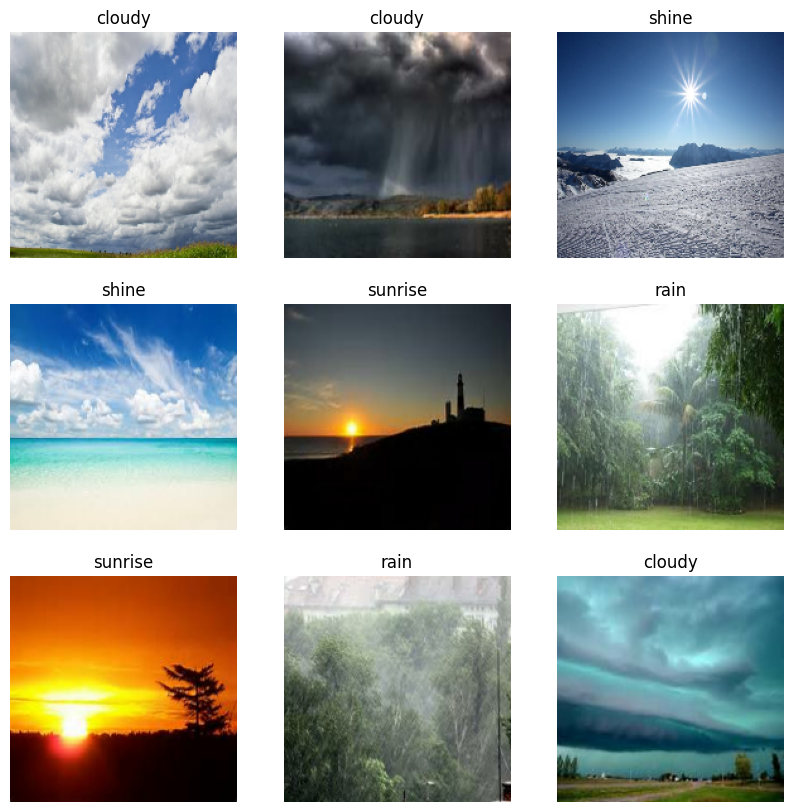

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13025056 0.7905229


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
from tensorflow import keras

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
   callbacks=callbacks
)

Epoch 1/10
25/25 [==============================] - 33s 1s/step - loss: 0.0371 - accuracy: 0.9873 - val_loss: 0.2922 - val_accuracy: 0.9107
Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.4424 - val_accuracy: 0.9018
Epoch 3/10
25/25 [==============================] - 36s 1s/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.5815 - val_accuracy: 0.8661
Epoch 4/10
25/25 [==============================] - 33s 1s/step - loss: 0.0536 - accuracy: 0.9733 - val_loss: 0.5495 - val_accuracy: 0.8661
Epoch 5/10
25/25 [==============================] - 32s 1s/step - loss: 0.0293 - accuracy: 0.9924 - val_loss: 0.3212 - val_accuracy: 0.8929
Epoch 6/10
25/25 [==============================] - 36s 1s/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.5191 - val_accuracy: 0.8839
Epoch 7/10
25/25 [==============================] - 34s 1s/step - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.4796 - val_accuracy: 0.9196
Epoch 8/10
25/25 [==

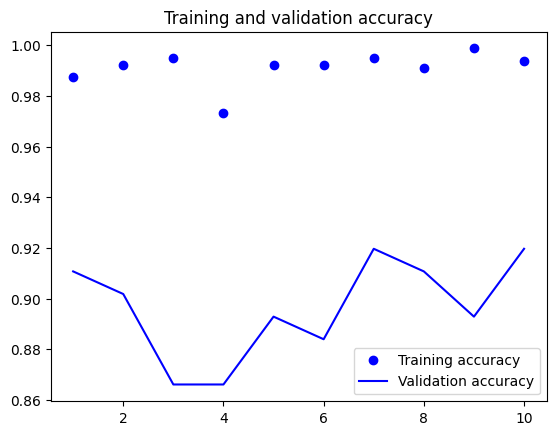

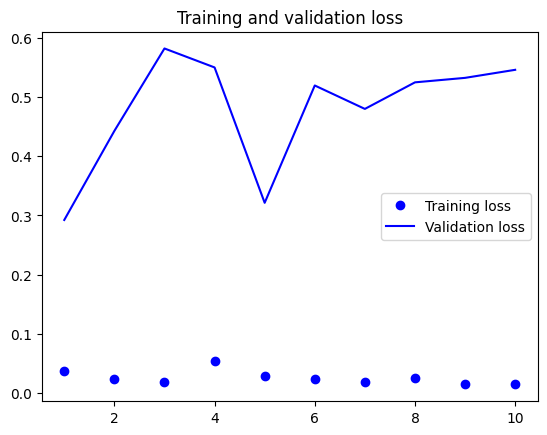

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 4s 333ms/step - loss: 0.4303 - accuracy: 0.8973
Test accuracy: 0.897


In [116]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

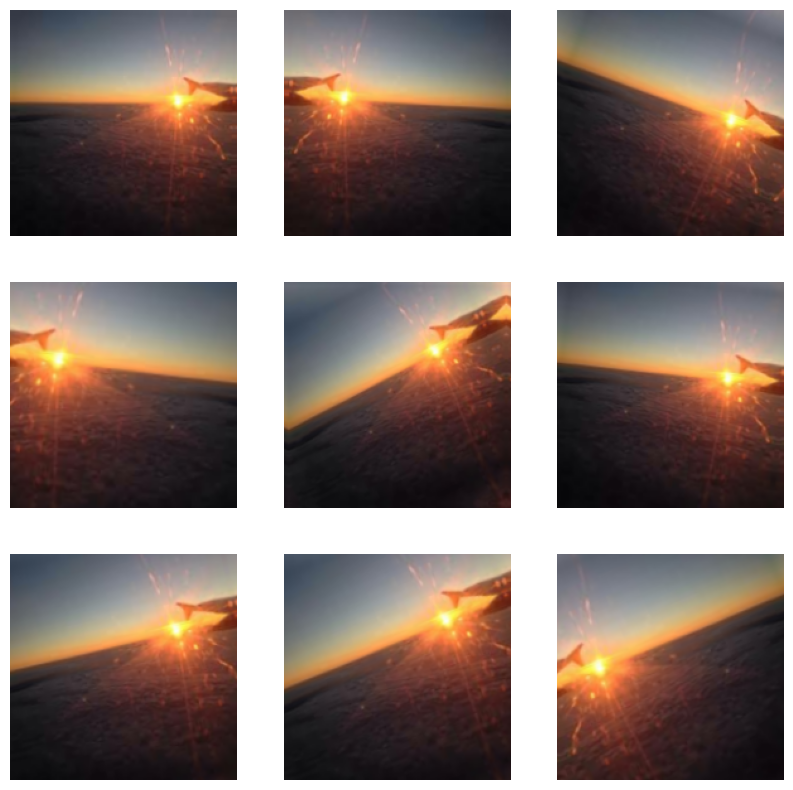

In [117]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [118]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [119]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - 73s 3s/step - loss: 1.1070 - accuracy: 0.5102 - val_loss: 0.9332 - val_accuracy: 0.4286
Epoch 2/10
25/25 [==============================] - 73s 3s/step - loss: 0.7972 - accuracy: 0.6489 - val_loss: 0.8332 - val_accuracy: 0.6250
Epoch 3/10
25/25 [==============================] - 73s 3s/step - loss: 0.6577 - accuracy: 0.7214 - val_loss: 0.8011 - val_accuracy: 0.6429
Epoch 4/10
25/25 [==============================] - 72s 3s/step - loss: 0.6035 - accuracy: 0.7328 - val_loss: 0.7540 - val_accuracy: 0.6607
Epoch 5/10
25/25 [==============================] - 70s 3s/step - loss: 0.5826 - accuracy: 0.7532 - val_loss: 0.6716 - val_accuracy: 0.6875
Epoch 6/10
25/25 [==============================] - 72s 3s/step - loss: 0.5474 - accuracy: 0.7621 - val_loss: 0.6935 - val_accuracy: 0.7054
Epoch 7/10
25/25 [==============================] - 72s 3s/step - loss: 0.5518 - accuracy: 0.7850 - val_loss: 0.6024 - val_accuracy: 0.7143
Epoch 8/10
25/25 [==

In [121]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 6s 661ms/step - loss: 0.6229 - accuracy: 0.7545
Test accuracy: 0.754
